In [4]:
## Text classification with preprocessed text: Movie reviews
# This is an example of binary—or two-class—classification 
# use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. 
# These are split into 25,000 reviews for training and 25,000 reviews for testing. 
# The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.
# TensorFlow Hub is a library for the publication, discovery, and consumption of reusable parts of machine learning models.

import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.2.0-dev20200501


In [6]:
# Download the IMDB dataset
    # Use the version pre-encoded with an ~8k vocabulary.
    # Return the train/test datasets as a tuple.  
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    # Also return the `info` structure. 
    
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',  
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised=True,
    with_info=True)

C:\Users\Nano\tensorflow_datasets\imdb_reviews\subwords8k\0.1.0
Using C:\Users\Nano\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0 instead.


Shuffling and writing examples to C:\Users\Nano\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteALH2ZF\imdb_reviews-train.tfrecord
Shuffling and writing examples to C:\Users\Nano\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteALH2ZF\imdb_reviews-test.tfrecord
Shuffling and writing examples to C:\Users\Nano\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteALH2ZF\imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to C:\Users\Nano\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


In [7]:
# Try the encoder
encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [8]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string)) 

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]


In [9]:
original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

The original string: "Hello TensorFlow."


In [10]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [19]:
# Explore the data

for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [20]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [21]:
# Prepare the data for training

BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))

test_batches = (
    test_data
    .padded_batch(32))

In [22]:
for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)
  

Batch shape: (32, 723)
label shape: (32,)
Batch shape: (32, 875)
label shape: (32,)


In [23]:
# Build the model
# The neural network is created by stacking layers—this requires two main architectural decisions:
# 1) How many layers to use in the model?
# 2) How many hidden units to use for each layer?

model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Loss function and optimizer

model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
# Train the model

history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Instructions for updating:
Use `tf.data.Dataset.cardinality()


Instructions for updating:
Use `tf.data.Dataset.cardinality()


Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.6803 - accuracy: 0.5011 - val_loss: 0.6615 - val_accuracy: 0.5073
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.6172 - accuracy: 0.5574 - val_loss: 0.5934 - val_accuracy: 0.6333
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.5389 - accuracy: 0.6692 - val_loss: 0.5317 - val_accuracy: 0.7302
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 0.4729 - accuracy: 0.7530 - val_loss: 0.4815 - val_accuracy: 0.7406
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4204 - accuracy: 0.8038 - val_loss: 0.4431 - val_accuracy: 0.8000
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3804 - accuracy: 0.8327 - val_loss: 0.4172 - val_accuracy: 0.8000
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3479 - accuracy: 0.8546 - val_loss: 0.3984 - val_accuracy: 0.8115
Epoch 

In [26]:
# Evaluate the model

loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3328 - accuracy: 0.8691
Loss:  0.3328428566455841
Accuracy:  0.8690800070762634


In [27]:
# Create a graph of accuracy and loss over time

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

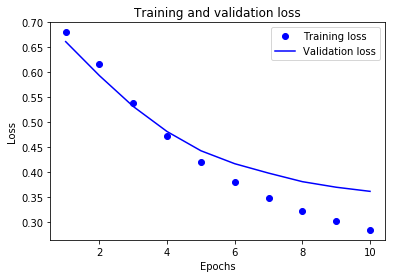

In [29]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

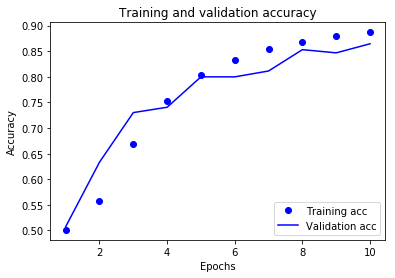

In [30]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()